# `AA Workshop 10` - Unsupervised Learning and Clustering

This workshop deals with `unsupervised learning`. In unsupervised learning, we are not trying to predict a continuous value (regression) or a discrete value/class (classification) based on a set of features, but instead we are trying to find (hidden) structures in the data. Therefore, there is no exact measure to tell if your algorithm does work well or does not. During this workshop, we will use clustering algorithms on datasets for which we __do__ have labels, just to give you a better intuition. In real world examples, however, assessing the quality of your clustering result is __more difficult__!

We will focus on hard clustering and review the following algorithms:
1. k-means
1. Principal Component Analysis (PCA)
1. Hierarchichal clustering


### Iris dataset
For a first intuition, we will be working on the iris dataset again, which you all are familiar with by now. As you remember, in reality there are __three__ different species of irises in the dataset. So let's see, whether we are able to confirm this number of __clusters__ in our dataset.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Recall the famous `iris.csv` dataset that we used to illustrate plotting routines earlier in the course

In [2]:
iris = pd.read_csv('iris.csv', index_col="number").dropna(axis=0)
iris.head()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
number,,,,,
1,5.1,3.5,1.4,0.2,setosa
2,4.9,3.0,1.4,0.2,setosa
3,4.7,3.2,1.3,0.2,setosa
4,4.6,3.1,1.5,0.2,setosa
5,5.0,3.6,1.4,0.2,setosa


In [3]:
X = iris.drop("Species", axis=1)
y = iris["Species"]
X.head()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
number,,,,
1,5.1,3.5,1.4,0.2
2,4.9,3.0,1.4,0.2
3,4.7,3.2,1.3,0.2
4,4.6,3.1,1.5,0.2
5,5.0,3.6,1.4,0.2


## Clustering

### Data Prep and Scaling
First, let's start out by scaling the data. The K-Means algorithm (and any other clustering algorithm for that matter) minimizes some inter-cluster distance. For the case of k-means this is typcially defined as the **euclidian distance** from the midpoint of each cluster to all points in this cluster. 

If one feature has a bigger spread, than others it will be more important than other factors for the outcome of the clustering. We will revisit this later! For now, let's normalize!

In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
X_scaled_df.head()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
number,,,,
1,-0.893244,1.002051,-1.333018,-1.300856
2,-1.137464,-0.139130,-1.333018,-1.300856
3,-1.381684,0.317342,-1.390008,-1.300856
4,-1.503795,0.089106,-1.276029,-1.300856
5,-1.015354,1.230287,-1.333018,-1.300856


In [5]:
iris_scaled = X_scaled_df
iris_scaled["Species"] = iris["Species"]

The typical patterns remain in the scaled data, just at a different scale.

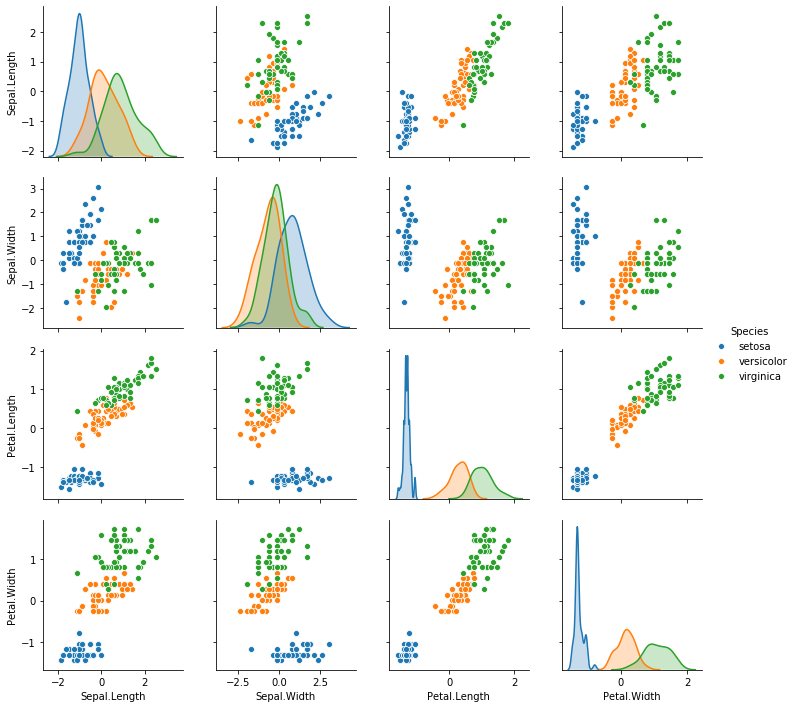

In [6]:
sns.pairplot(data=iris_scaled, hue="Species")

## Supervised Learning Case

Before we start with the actual clustering, let's revisit the classification methods we talked about during last week's lecture and see how well they are doing in terms of classification error. For that, we are importing a `kNN classifier` from the sklearn library and have a look at the confusion matrix the classification report.

kNN has some intutive parallels to k-means clustering (see lecture material)

In [7]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

In [8]:
model_neigh = KNeighborsClassifier(n_neighbors=15)
 

In [9]:
model_neigh.fit(X_scaled,y)    # We are also not doing a train-test-split or other advanced methods here
                       # This is not a valid approach for a real supervised learning project!

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                     weights='uniform')

In [10]:
y_pred = model_neigh.predict(X_scaled)

To review the performance of our classifier we check relevant test metric, that you are familiar with by now. We use the `classification_report` class to return a neat summary of the most important classification metrics. We also review the previously discussed `confusion_matrix`.

Compute precision, recall, F-measure and support for each class.

The precision is the ratio `tp / (tp + fp)` where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label a negative sample as positive.

The recall is the ratio `tp / (tp + fn)` where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

The F-beta score can be interpreted as a weighted harmonic mean of the precision and recall, where an F-beta score reaches its best value at 1 and worst score at 0.

The F-beta score weights recall more than precision by a factor of `beta`. `beta == 1.0` means recall and precision are equally important.

The support is the number of occurrences of each class in `y_true`.



In [11]:
iris["SpeciesPred"] = y_pred
print(classification_report(y,y_pred)) # classification_report is a useful summary function that returns a range of classification metrics 

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        49
  versicolor       0.94      0.98      0.96        49
   virginica       0.98      0.94      0.96        48

    accuracy                           0.97       146
   macro avg       0.97      0.97      0.97       146
weighted avg       0.97      0.97      0.97       146



In [12]:
confusion_matrix(y,y_pred)

array([[49,  0,  0],
       [ 0, 48,  1],
       [ 0,  3, 45]])

## Unsupervised Learning Case - K-Means
Now, let's keep the labels out and let's just have a look at the given features. How would we group the datapoints for the different observed flowers?
In a typical unsupervised learning case we normally just have a rough idea of how many clusters to expect.

Three approaches are commonly applied:
1. Use expert knowledge
1. Plot residual loss for different number of clusters, find 'elbow' and select corresponding number of clusters
1. Use hierarchical clustering to detect suitable braching and corresponding number of clusters

We will focus on the residual loss as selection criteria for now. In practice a combination of all three 

In [13]:
from sklearn.cluster import KMeans

In [14]:
k_max = 50  # We have c. 150 datapoints, more than 50 clusters are definitely
            # not reasonable!

In [15]:
clusters = []
losses = []

for k in range(k_max):
    model = KMeans(n_clusters=k+1)
    model.fit(X_scaled)
    clusters.append(k+1)
    losses.append(model.inertia_)

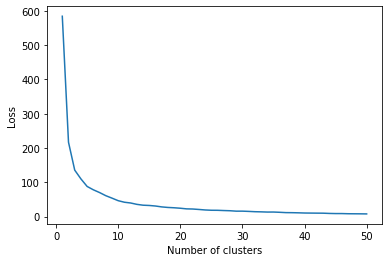

In [16]:
plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.show()

Let's zoom in a bit...

(0, 10)

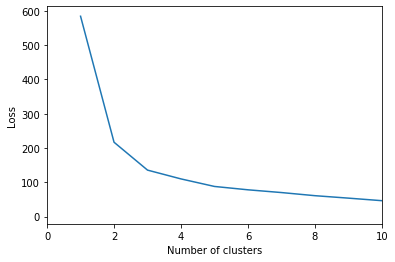

In [17]:
plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.xlim([0,10])

From this plot we would expect a good amount of clusters to lie in the region of two to five. For illustrative purposes let's select the minimum of two.

In [18]:
# refit algorithm
two_means = KMeans(n_clusters=2)
two_means.fit(X_scaled)

# match records to clusters by calling predict
two_means.predict(X_scaled)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

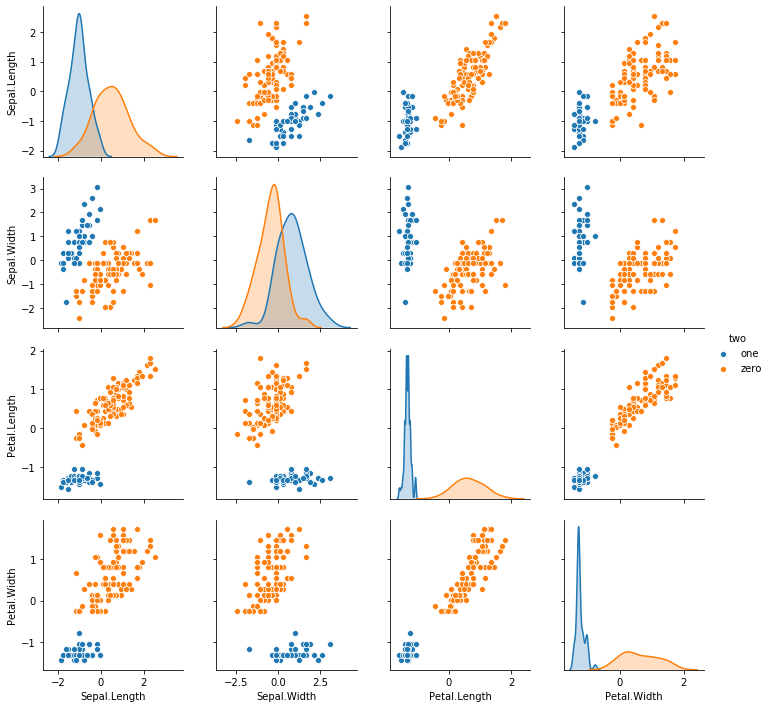

In [19]:
numbers = ["zero", "one", "two", "three"]

iris_scaled["two"] = two_means.predict(X_scaled)
iris_scaled["two"] = iris_scaled["two"].apply(lambda x: numbers[x])
sns.pairplot(data=iris_scaled, hue="two")

Now let's do this for the "correct" number of cluster, i.e., three.

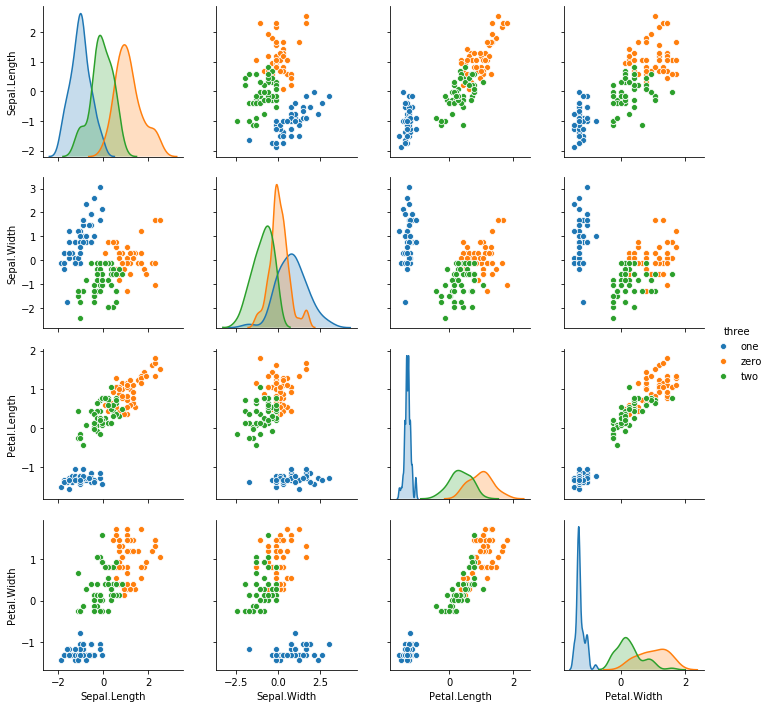

In [20]:
three_means = KMeans(n_clusters=3)
three_means.fit(X_scaled)
iris_scaled["three"] = three_means.predict(X_scaled)
iris_scaled["three"] = iris_scaled["three"].apply(lambda x: numbers[x])
sns.pairplot(data=iris_scaled, hue="three")

## Principal Component Analysis (PCA)
In the case of the iris dataset, we have just four features - an amount we can still easily manage. But imagine we have a much larger features space. Then, it might be necessary to reduce the dimensionality of our dataset. Also, we gain another advantage: We can visualize the data more easily! As you have seen above, already with just 4 dimensions it is hard to visualize our data in a meaningful way. The size of a pairplot increases quadratically with the number of features. For four features we have sixteen plots (more than you should expect any stakeholder to have a look at/understand ...), but for 10 features it is already a hundred. (way more than you would like to have to look at!)

So, how do we reduce the dimensionality of our dataset without losing two much information? (unfortunately, we are always losing some.)


Principal component analysis (PCA) is the way to go! Using PCA, we are looking at our data and try to find a projection, which keeps most of the variance within the data. As this is a little theoretical, let's have a quick look at graphical example:

![pca](pca.png)

Here, our data originally had two dimensions and is reduced onto just one dimension. As you can see, most of the variance of our data is conserved. If the datapoints are very crooked in space, it is a little harder to find the "principal components". For this, there arer advanced options like for example Kernel-PCA (which we are not talking about in this course). 

Furthermore, there is one more important application for PCA: When there are more features than records in your dataset, you can reduce the dimensionality of your dataset to the number of records without losing any information! So if you have 1 million features but only 100 records, then it is sufficient to look at only the first 100 principal components and you will not have lost any variance. Still, it can be useful to reduce the number of dimensions further in case that you do not lose too much variance.

As a rule of thumb, there should be at least 95% of the original variance left in the dataset. Let's now run a PCA on our iris dataset and have a look at the principal components.

In [21]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
X_pca = pca.fit_transform(X_scaled)

In [22]:
pca.components_

array([[ 0.5215428 , -0.26325264,  0.58136097,  0.56631315]])

In [23]:
print(pca.explained_variance_ratio_[0])

0.727162557940516


In [24]:
pca2 = PCA(n_components=2)
X_pca2 = pca2.fit_transform(X_scaled)

In [25]:
print(pca2.explained_variance_ratio_)
print(sum(pca2.explained_variance_ratio_))

[0.72716256 0.23108571]
0.9582482724875816


Using only two principal components, we still have approx. 96% of our variance, so we can assume that the transformed dataset is a good approximation of our original dataset. Let's now have a closer look at how each of these two principal components is composed.

In [26]:
print(pca2.components_)
print(list(X_scaled_df.columns)[:4])

[[ 0.5215428  -0.26325264  0.58136097  0.56631315]
 [ 0.37682198  0.92393738  0.01878068  0.0631838 ]]
['Sepal.Length', 'Sepal.Width', 'Petal.Length', 'Petal.Width']


In [27]:
iris_pca = pd.DataFrame(X_pca2, columns=["First PC", "Second PC"], index=iris.index)
iris_pca["Species"] = iris["Species"]
iris_pca.head()

,First PC,Second PC,Species
number,,,
1,-2.241314,0.482010,setosa
2,-2.068267,-0.664397,setosa
3,-2.348937,-0.335743,setosa
4,-2.286276,-0.590492,setosa
5,-2.365084,0.646872,setosa


Before running a clustering algorithm on the reduced data, let's first have a look what we would have seen using only one principal component!

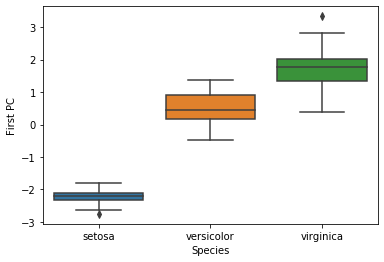

In [28]:
sns.boxplot(x="Species", y="First PC", data=iris_pca)

We are (as expected) already able to differentiate between *setosa* and the other two types easily using just the first principal component. There is a clear difference between the core elements of the other two clusters, but it is not possible to completely differentiate between them.

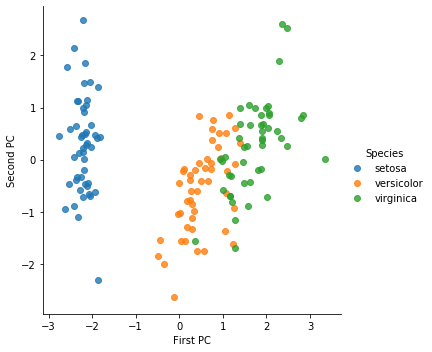

In [29]:
sns.lmplot(x="First PC", y="Second PC", data=iris_pca, fit_reg=False, hue="Species")

Let's now use K-means again to find clusters in this reduced 2-dimensional space! 

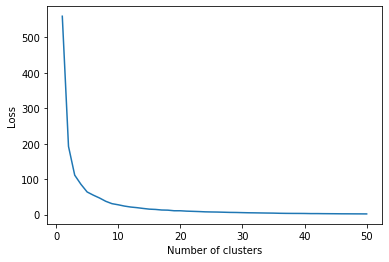

In [30]:
pca_clusters = []
pca_losses = []

for i in range(k_max):
    model = KMeans(n_clusters=i+1)
    model.fit(X_pca2)
    pca_clusters.append(i+1)
    pca_losses.append(model.inertia_)
    
plt.plot(pca_clusters, pca_losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.show()

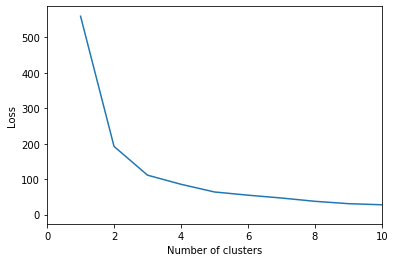

In [31]:
plt.plot(pca_clusters, pca_losses)
plt.xlim([0,10])
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.show()

In [32]:
pca_three_means = KMeans(n_clusters=3)
pca_three_means.fit(X_pca2)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

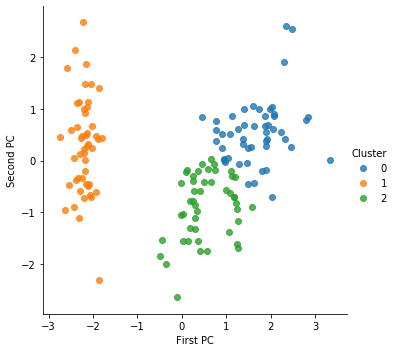

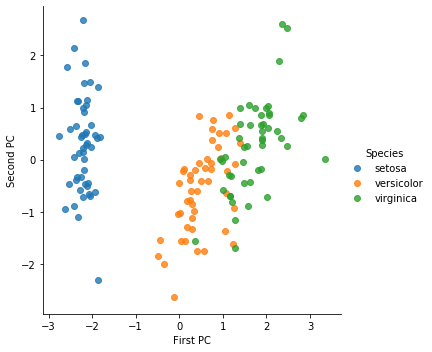

In [33]:
iris_pca["Cluster"] = pca_three_means.predict(X_pca2)
sns.lmplot(x="First PC", y="Second PC", hue="Cluster", data=iris_pca, fit_reg=False)
sns.lmplot(x="First PC", y="Second PC", hue="Species", data=iris_pca, fit_reg=False)

**Exercise:** Use all methods for unsupervised learning shown here and try to find clusters in the (prepepared) cancer dataset! How many principal components do you need? Can you still plot your data in a meaningful way? Would you have chosen the number of clusters as 2 without knowing that there are only two cancer types? 

In [34]:
cancer = pd.read_csv('breast_cancer.csv', index_col="id")
cancer.dropna(axis=1, inplace=True)
cancer_wo_target = cancer.drop("diagnosis", axis=1)

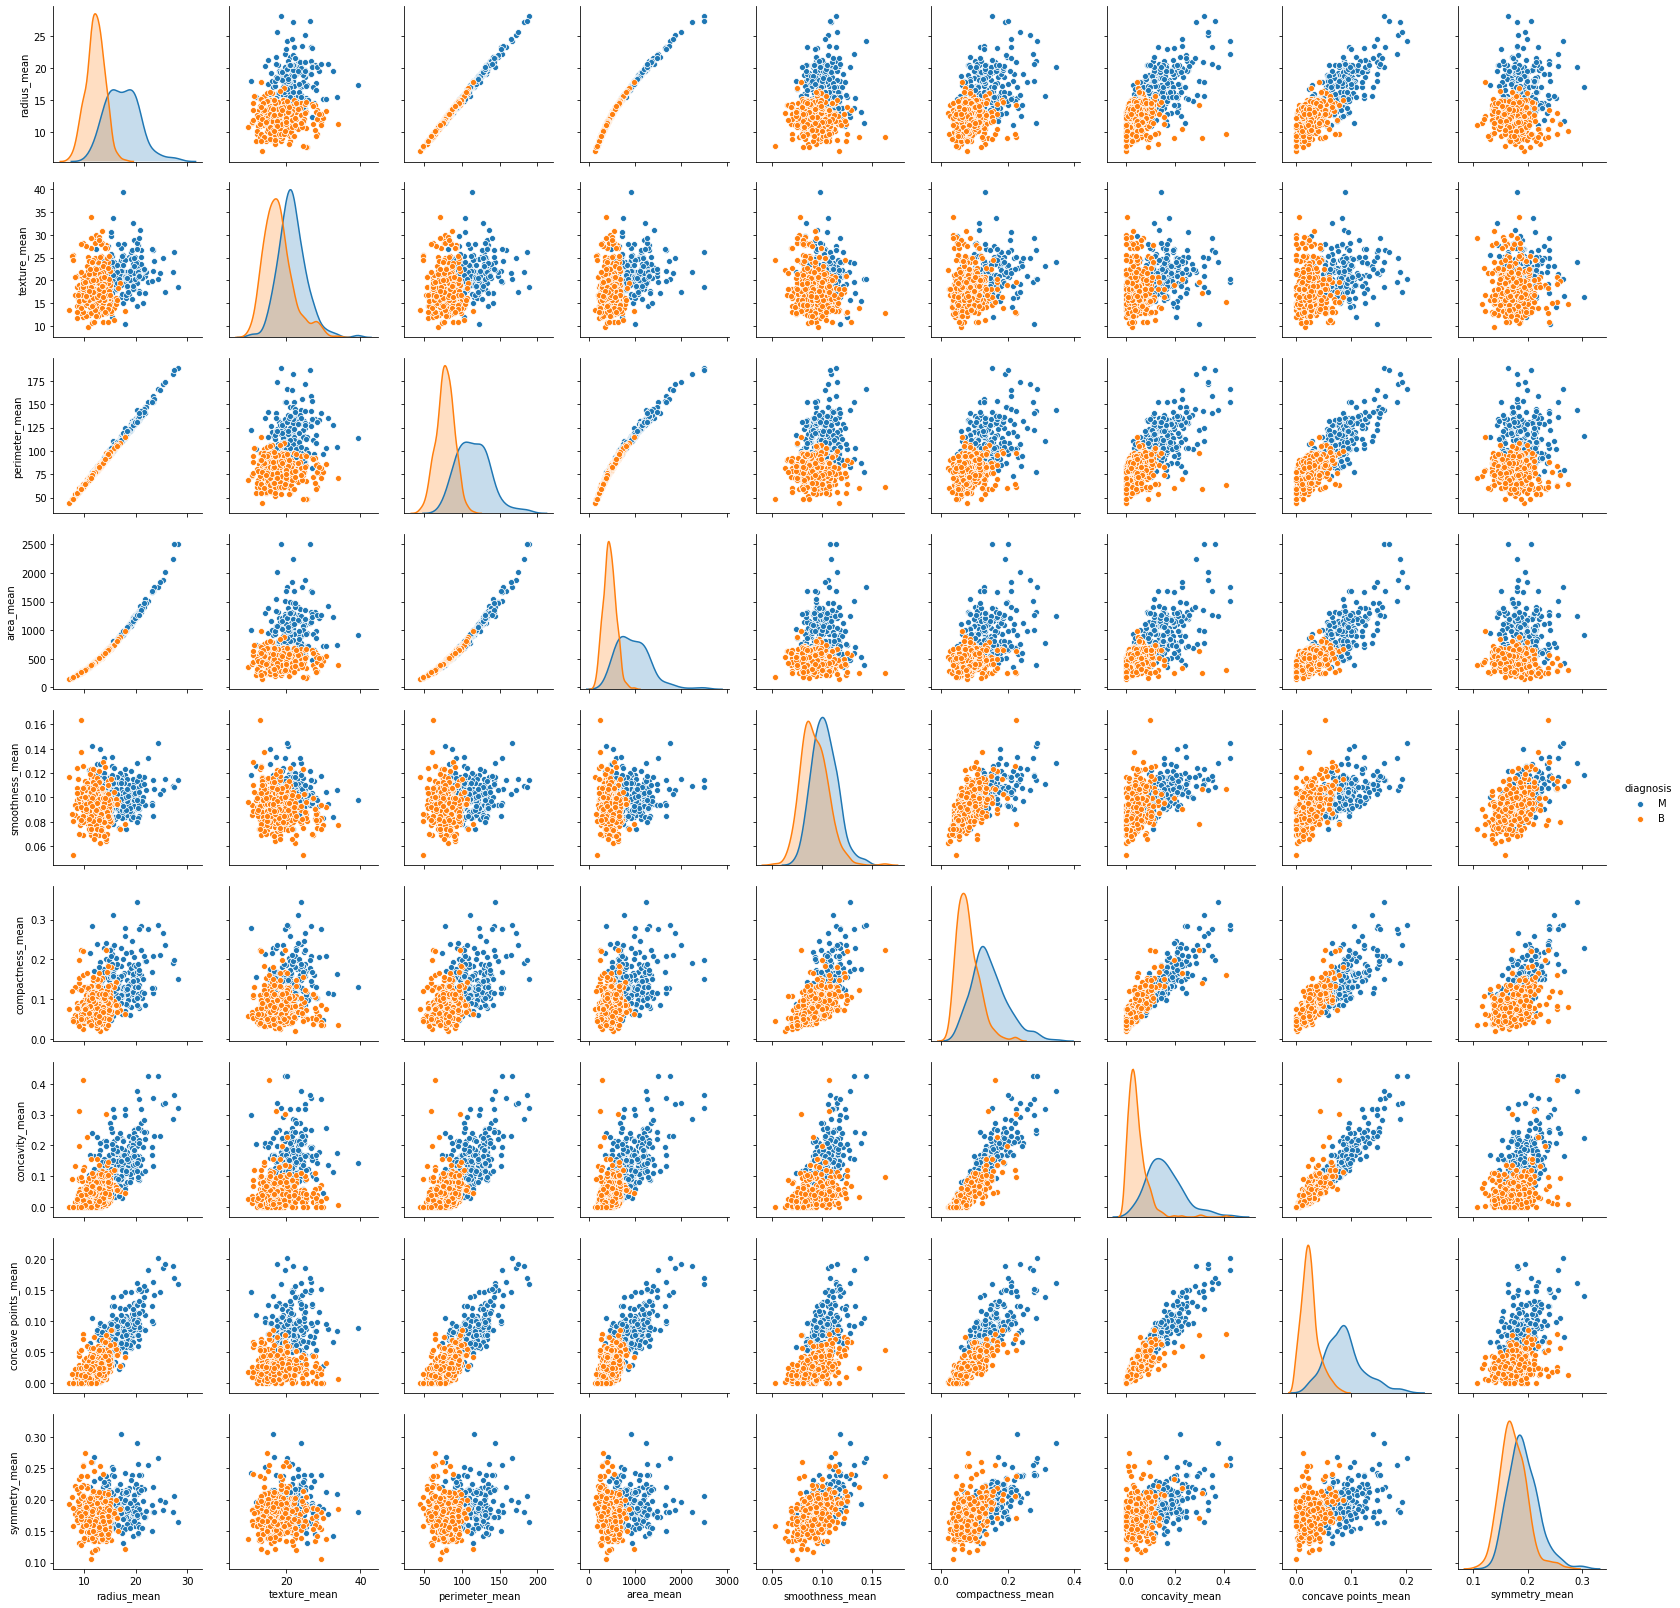

In [35]:
g = sns.pairplot(data=cancer[cancer.columns[:10]], hue="diagnosis")

In [36]:
cancer_wo_target.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
id,,,,,,,,,,,,,,,,,,,,,
842302,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
842517,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
84300903,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
84348301,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
84358402,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [37]:
# Scale features

scaler = StandardScaler()
cancer_scaled = pd.DataFrame(scaler.fit_transform(cancer_wo_target))

In [38]:
cancer_scaled.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,1.097064,-2.073335,1.269934,0.984375,1.568466,3.283515,2.652874,2.532475,2.217515,2.255747,...,1.886690,-1.359293,2.303601,2.001237,1.307686,2.616665,2.109526,2.296076,2.750622,1.937015
1,1.829821,-0.353632,1.685955,1.908708,-0.826962,-0.487072,-0.023846,0.548144,0.001392,-0.868652,...,1.805927,-0.369203,1.535126,1.890489,-0.375612,-0.430444,-0.146749,1.087084,-0.243890,0.281190
2,1.579888,0.456187,1.566503,1.558884,0.942210,1.052926,1.363478,2.037231,0.939685,-0.398008,...,1.511870,-0.023974,1.347475,1.456285,0.527407,1.082932,0.854974,1.955000,1.152255,0.201391
3,-0.768909,0.253732,-0.592687,-0.764464,3.283553,3.402909,1.915897,1.451707,2.867383,4.910919,...,-0.281464,0.133984,-0.249939,-0.550021,3.394275,3.893397,1.989588,2.175786,6.046041,4.935010
4,1.750297,-1.151816,1.776573,1.826229,0.280372,0.539340,1.371011,1.428493,-0.009560,-0.562450,...,1.298575,-1.466770,1.338539,1.220724,0.220556,-0.313395,0.613179,0.729259,-0.868353,-0.397100


In [39]:
# Run PCA to reduce dimensionality
pca = PCA(n_components=10)
cancer_scaled_pca = pca.fit_transform(cancer_scaled)

In [40]:
sum(pca.explained_variance_ratio_)

0.9515688143125901

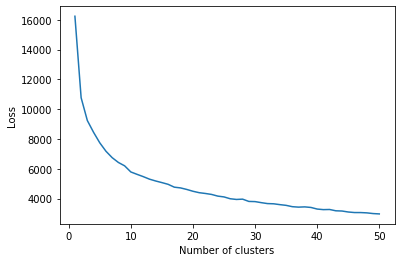

In [41]:
clusters = []
losses = []

for i in range(k_max):
    model = KMeans(n_clusters=i+1)
    model.fit(cancer_scaled_pca)
    clusters.append(i+1)
    losses.append(model.inertia_)
    
plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.show()

(0, 10)

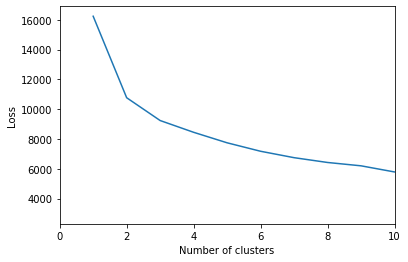

In [42]:
plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.xlim([0,10])

In [43]:
cancer_two = KMeans(n_clusters=2)
cancer_two.fit(cancer_scaled_pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [44]:
cancer_two.predict(cancer_scaled_pca)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,

In [45]:
cancer_scaled_pca_df = pd.DataFrame(cancer_scaled_pca, index=cancer.index)
cancer_scaled_pca_df.columns = ["PC"+str(column+1) for column in cancer_scaled_pca_df.columns]

In [46]:
cancer_scaled_pca_df["Cluster"] = cancer_two.predict(cancer_scaled_pca)
cancer_scaled_pca_df["Diagnosis"] = cancer["diagnosis"]
cancer_scaled_pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,Cluster,Diagnosis
id,,,,,,,,,,,,
842302,9.192837,1.948583,-1.123166,3.633731,-1.195110,1.411424,2.159368,-0.398386,-0.157138,-0.877349,1,M
842517,2.387802,-3.768172,-0.529293,1.118264,0.621775,0.028656,0.013359,0.240982,-0.711899,1.106976,1,M
84300903,5.733896,-1.075174,-0.551748,0.912083,-0.177086,0.541452,-0.668166,0.097357,0.024076,0.454240,1,M
84348301,7.122953,10.275589,-3.232790,0.152547,-2.960878,3.053422,1.429912,1.059532,-1.405416,-1.117050,1,M
84358402,3.935302,-1.948072,1.389767,2.940639,0.546747,-1.226495,-0.936213,0.636381,-0.263809,0.377715,1,M


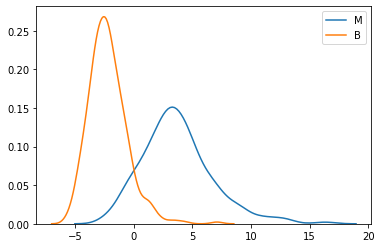

In [47]:
ax = sns.kdeplot(cancer_scaled_pca_df[cancer_scaled_pca_df["Diagnosis"]=="M"]["PC1"], label='M')
ax = sns.kdeplot(cancer_scaled_pca_df[cancer_scaled_pca_df["Diagnosis"]=="B"]["PC1"], label='B')

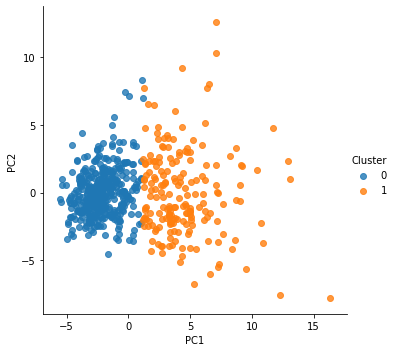

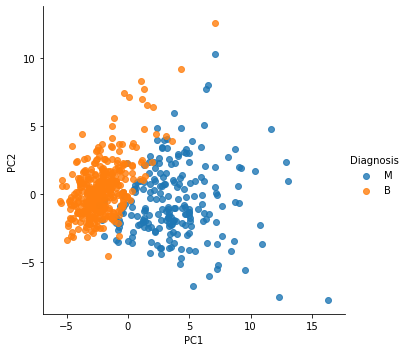

In [48]:
sns.lmplot(x="PC1", y="PC2", data=cancer_scaled_pca_df, fit_reg=False, hue="Cluster")
sns.lmplot(x="PC1", y="PC2", data=cancer_scaled_pca_df, fit_reg=False, hue="Diagnosis")

## `Hierarchical Clustering`

Unlike k-Means, hierarchical clustering defines step-wise decision rules of how to seperate the data into clusters. This has the advantage that it is more resembling the human decision making process and is therefore very intuitive for stakeholders to understand. Let's have a look at how a decision tree would look like for our iris dataset.

## Supervised Learning Case

The supervised equivalent of heirarchichal clustering is decision tree classification which we will briefly re-visit in this section.

In [49]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz 
#import pydotplus
#from IPython.display import Image

In [50]:
tree = DecisionTreeClassifier(max_depth=2)

In [51]:
X["Petal.Area"] = X["Petal.Length"]*X["Petal.Width"]
#X.drop("Petal.Area", axis=1, inplace=True)
tree.fit(X, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [52]:
y_pred_tree = tree.predict(X)

In [53]:
print(classification_report(y_pred=y_pred_tree, y_true=y))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        49
  versicolor       1.00      0.92      0.96        49
   virginica       0.92      1.00      0.96        48

    accuracy                           0.97       146
   macro avg       0.97      0.97      0.97       146
weighted avg       0.97      0.97      0.97       146



In [54]:
dot_data = export_graphviz(tree, out_file=None, 
                           class_names=iris["Species"].unique(), 
                           feature_names=X.columns)  

graph = graphviz.Source(dot_data) 
#graph = pydotplus.graph_from_dot_data(dot_data)

graph.render("iris") 

'iris.pdf'

![Rendered tree](iris.pdf)

### Unsupervised Learning Case

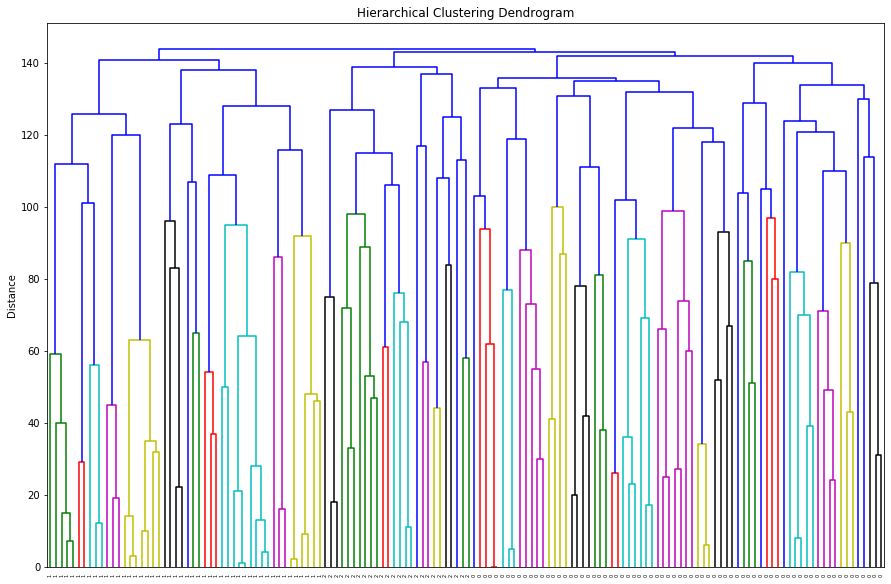

In [55]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):

    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


agglo = AgglomerativeClustering(n_clusters=3) #The number of clusters to find
y_pred_agglo = agglo.fit_predict(X_scaled)

plt.figure(figsize=(15,10))
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(agglo, labels=agglo.labels_)
plt.ylabel("Distance")
plt.show()

In [56]:
iris_pca["Agglo"] = y_pred_agglo

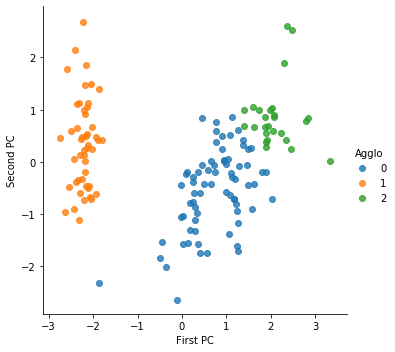

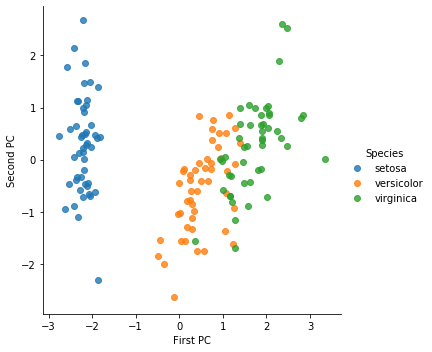

In [57]:
sns.lmplot(x="First PC", y="Second PC", data=iris_pca, fit_reg=False, hue="Agglo")
sns.lmplot(x="First PC", y="Second PC", hue="Species", data=iris_pca, fit_reg=False)

---